In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing.image import array_to_img
from keras.src.utils import img_to_array

In [ ]:
# Set the display option to show all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

directory_path = "/Volumes/_blapblap/FYP IMAGES/images (image aug)/PlantImages"

def count_files_in_directory(directory_path):
    file_count = 0

    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        if os.path.isfile(item_path):
            file_count += 1

    return file_count

def get_directory_data(directory_path):
    data = []

    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        if os.path.isdir(item_path):
            file_count = count_files_in_directory(item_path)
            data.append({"Directory": os.path.basename(item_path), "File Count": file_count})

            # Recursively get data for subdirectories
            data.extend(get_directory_data(item_path))

    return data

# Get directory data
directory_data = get_directory_data(directory_path)

# Convert data to DataFrame
df = pd.DataFrame(directory_data)

# Display the DataFrame
df


In [ ]:
count = 0

for item in os.listdir(directory_path):
    item_path = os.path.join(directory_path, item)

    if os.path.isfile(item_path):
        count += 1

    elif os.path.isdir(item_path):
        for sub_item in os.listdir(item_path):
            sub_item_path = os.path.join(item_path, sub_item)
            if os.path.isfile(sub_item_path):
                count += 1

print("File Count:", count)

In [ ]:
import os
import shutil

directory_path = "/Users/rohan/Desktop/FinalProject /FYP /new code/PlantImages/New_Images/PlantImages"

# Define a function to cap the number of images in each subdirectory
def cap_images(directory_path, max_count=2000):
    for root, dirs, files in os.walk(directory_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            file_count = 0
            for file_name in os.listdir(dir_path):
                file_path = os.path.join(dir_path, file_name)
                if os.path.isfile(file_path):
                    file_count += 1
            if file_count > max_count:
                print(f"Directory '{dir_name}' exceeds the maximum count of {max_count} images.")
                print(f"Capping images in directory '{dir_name}' to {max_count}...")
                # Sort files by modification time (oldest first)
                files = sorted(os.listdir(dir_path), key=lambda x: os.path.getmtime(os.path.join(dir_path, x)))
                # Remove excess files beyond the cap
                for file_name in files[max_count:]:
                    file_path = os.path.join(dir_path, file_name)
                    os.remove(file_path)
                print(f"Successfully capped images in directory '{dir_name}'.")
            else:
                print(f"Directory '{dir_name}' does not exceed the maximum count.")

# Call the function to cap the number of images
cap_images(directory_path)


In [ ]:
import os
import matplotlib.pyplot as plt

directory_path = "/Users/rohan/Desktop/FinalProject /FYP /new code/PlantImages/New_Images/PlantImages"
file_counts = {}

for item in os.listdir(directory_path):
    item_path = os.path.join(directory_path, item)

    if os.path.isdir(item_path):
        count = 0
        for sub_item in os.listdir(item_path):
            sub_item_path = os.path.join(item_path, sub_item)
            if os.path.isfile(sub_item_path):
                count += 1
        file_counts[item] = count

# Sort the dictionary by keys (directory names)
sorted_file_counts = dict(sorted(file_counts.items()))

# Create bar graph
plt.figure(figsize=(10, 6))
plt.bar(sorted_file_counts.keys(), sorted_file_counts.values(), color='skyblue')
plt.xlabel('Directory')
plt.ylabel('File Count')
plt.title('File Count in Each Directory')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import os
import imgaug as ia
import imgaug.augmenters as iaa
from PIL import Image
import numpy as np

def augment_image(image_path, aug, save_dir, idx):
    image = Image.open(image_path)
    image_np = np.array(image)
    image_aug = aug(image=image_np)
    
    # Convert RGBA to RGB
    if image_aug.shape[-1] == 4:  # If the image is RGBA
        # Convert to RGB by filling the alpha with white background
        image_aug_rgb = Image.fromarray(image_aug).convert('RGB')
    else:
        image_aug_rgb = Image.fromarray(image_aug)
    
    image_aug_rgb.save(os.path.join(save_dir, f"aug_{idx}_{os.path.basename(image_path)}"), format='JPEG')


def is_image_file(filename):
    # Add or remove image extensions as needed
    valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

def augment_images_in_directory(directory, target_count=2000):
    # Define your augmentations here
    aug = iaa.Sequential([
        iaa.Fliplr(0.5),  # Horizontal flip
            iaa.Flipud(0.2),  # Vertical flip
            iaa.Crop(percent=(0, 0.1)),  # Random crops
            # Scale images to 80-120% of their size, individually per axis
            iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
            iaa.Affine(rotate=(-25, 25)),  # Rotate by -25 to +25 degrees
            iaa.Affine(shear=(-16, 16)),  # Shear by -16 to +16 degrees
            iaa.GaussianBlur(sigma=(0, 3.0)),  # Blur by 0 to 3.0 sigma
            iaa.Multiply((0.5, 1.5)),  # Change brightness (50-150%)
            iaa.LinearContrast((0.75, 1.5)),  # Improve or worsen the contrast
            iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add gaussian noise
            iaa.PerspectiveTransform(scale=(0.01, 0.1))  # Perspective transformations
    ])
    
    images = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and is_image_file(f)]
    current_count = len(images)
    
    for idx, image_name in enumerate(images):
        if current_count >= target_count:
            break
        image_path = os.path.join(directory, image_name)
        augment_image(image_path, aug, directory, idx)
        current_count += 1

def main():
    base_directory = "/Volumes/_blapblap/FYP IMAGES/images (image aug)/PlantImages"
    for plant_type in os.listdir(base_directory):
        plant_dir = os.path.join(base_directory, plant_type)
        if os.path.isdir(plant_dir):
            augment_images_in_directory(plant_dir)
            print(f"Finished augmenting images for {plant_type}")

if __name__ == "__main__":
    main()


In [ ]:
# Set the display option to show all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

directory_path = "/Volumes/_blapblap/FYP IMAGES/images (image aug)/PlantImages"

def count_files_in_directory(directory_path):
    file_count = 0

    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        if os.path.isfile(item_path):
            file_count += 1

    return file_count

def get_directory_data(directory_path):
    data = []

    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)

        if os.path.isdir(item_path):
            file_count = count_files_in_directory(item_path)
            data.append({"Directory": os.path.basename(item_path), "File Count": file_count})

            # Recursively get data for subdirectories
            data.extend(get_directory_data(item_path))

    return data

# Get directory data
directory_data = get_directory_data(directory_path)

# Convert data to DataFrame
df = pd.DataFrame(directory_data)

# Display the DataFrame
df


In [ ]:
import os
import matplotlib.pyplot as plt

directory_path = "/Volumes/_blapblap/FYP IMAGES/images (image aug)/PlantImages"
directory_counts = {}

for item in os.listdir(directory_path):
    item_path = os.path.join(directory_path, item)

    if os.path.isdir(item_path):
        count = 0
        for sub_item in os.listdir(item_path):
            sub_item_path = os.path.join(item_path, sub_item)
            if os.path.isfile(sub_item_path):
                count += 1
        directory_counts[item] = count

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(directory_counts.keys(), directory_counts.values())
plt.xlabel('Directories')
plt.ylabel('File Count')
plt.title('File Count in Each Directory')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Base directory for the dataset and for the splits
base_dataset_path = '/Volumes/_blapblap/FYP IMAGES/images (image aug)/PlantImages'
base_train_path = '/Volumes/_blapblap/FYP IMAGES/images (image aug)/split/train'
base_val_path = '/Volumes/_blapblap/FYP IMAGES/images (image aug)/split/val'
base_test_path = '/Volumes/_blapblap/FYP IMAGES/images (image aug)/split/test'

# Collect all image paths
image_paths = []
labels = []

for root, dirs, files in os.walk(base_dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filter for image files
            path = os.path.join(root, file)
            label = os.path.relpath(root, base_dataset_path)  # Get the relative path as label
            image_paths.append(path)
            labels.append(label)

# Split the dataset
train_paths, test_val_paths, train_labels, test_val_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_val_paths, test_val_labels, test_size=0.5, stratify=test_val_labels, random_state=42)

# Function to copy files to their respective directories
def copy_files(file_paths, destination_base, labels):
    for file_path, label in zip(file_paths, labels):
        destination_path = os.path.join(destination_base, label)
        os.makedirs(destination_path, exist_ok=True)  # Create target directory if it doesn't exist
        shutil.copy(file_path, destination_path)

# Copy files to the respective directories
copy_files(train_paths, base_train_path, train_labels)
copy_files(val_paths, base_val_path, val_labels)
copy_files(test_paths, base_test_path, test_labels)

print(f"Training images copied: {len(train_paths)}")
print(f"Validation images copied: {len(val_paths)}")
print(f"Testing images copied: {len(test_paths)}")


In [ ]:
import os
import matplotlib.pyplot as plt

# Paths for dataset and splits
base_train_path = '/Volumes/_blapblap/FYP IMAGES/images (image aug)/split/train'
base_val_path = '/Volumes/_blapblap/FYP IMAGES/images (image aug)/split/val'
base_test_path = '/Volumes/_blapblap/FYP IMAGES/images (image aug)/split/test'

def total_images(base_path):
    """
    Counts the total number of images within the base_path, including all subdirectories.
    """
    total_count = 0
    for root, dirs, files in os.walk(base_path):
        total_count += len([file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return total_count

# Count total images in each split
train_total = total_images(base_train_path)
val_total = total_images(base_val_path)
test_total = total_images(base_test_path)

# Data for plotting
split_names = ['Train', 'Validation', 'Test']
image_counts = [train_total, val_total, test_total]

# Plotting
fig, ax = plt.subplots()
ax.bar(split_names, image_counts, color=['blue', 'orange', 'green'])

ax.set_ylabel('Number of Images')
ax.set_title('Total Images by Dataset Split')
ax.set_xticks(range(len(split_names)))
ax.set_xticklabels(split_names)

# Display the number of images on top of each bar
for i, count in enumerate(image_counts):
    ax.text(i, count + 2, str(count), ha='center', va='bottom')

plt.show()


In [ ]:
from PIL import Image
import os

def resize_images_in_folder(folder_path, target_size=(256, 256)):
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        # Check if the file is a subdirectory (folder)
        if os.path.isdir(filepath):
            # If it's a folder, recursively resize images in that folder
            resize_images_in_folder(filepath, target_size)
        else:
            try:
                # Open the image file
                with Image.open(filepath) as img:
                    # Resize the image
                    resized_img = img.resize(target_size)
                    # Save the resized image, overwriting the original
                    resized_img.save(filepath)
            except Exception as e:
                print(f"Error processing {filepath}: {e}")

# Define the base paths for train, validation, and test sets
base_train_path = '/Volumes/_blapblap/FYP IMAGES/images (image aug)/split/train'
base_val_path = '/Volumes/_blapblap/FYP IMAGES/images (image aug)/split/val'
base_test_path = '/Volumes/_blapblap/FYP IMAGES/images (image aug)/split/test'

# Resize images in the train, validation, and test sets
resize_images_in_folder(base_train_path)
resize_images_in_folder(base_val_path)
resize_images_in_folder(base_test_path)

print("All images resized successfully.")


In [ ]:
from PIL import Image
import os

def remove_corrupted_images(directory_path):
    removed_count = 0
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        img.verify()  # Verify if the image is readable
                except (IOError, SyntaxError) as e:
                    print(f"Removing corrupted file: {img_path}")  # Indicate which file is being removed
                    os.remove(img_path)  # Remove the corrupted file
                    removed_count += 1
    print(f"Removed {removed_count} corrupted image files.")

# Replace 'directory_path' with the path to your dataset
remove_corrupted_images('/Users/rohan/Desktop/FinalProject /FYP /new code/new_plant_images/split')


In [1]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator (rescale=1./256, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./256)

In [2]:
train_generator = train_datagen.flow_from_directory('/Users/rohan/Desktop/FinalProject /FYP /new code/new_plant_images/split/train',
                                                    target_size= (256, 256),
                                                    batch_size=16,
                                                    class_mode= 'categorical')

validation_generator = test_datagen.flow_from_directory('/Users/rohan/Desktop/FinalProject /FYP /new code/new_plant_images/split/val',
                                                         target_size= (256, 256),
                                                         batch_size=16,
                                                         class_mode= 'categorical')

Found 74376 images belonging to 64 classes.
Found 15939 images belonging to 64 classes.


In [3]:
# Check classes in train_generator
train_classes = train_generator.class_indices
print("Training Classes:", train_classes)

# Check classes in validation_generator
validation_classes = validation_generator.class_indices
print("Validation Classes:", validation_classes)


Training Classes: {'Alstonia Scholaris (Diseased)': 0, 'Alstonia Scholaris (Healthy)': 1, 'Apple (Healthy)': 2, 'Apple Applescab (Diseased)': 3, 'Apple Blackrot (Diseased)': 4, 'Apple Cedarapplerust (Diseased)': 5, 'Arjun (Diseased)': 6, 'Arjun (Healthy)': 7, 'Bell_pepper leaf (Healthy)': 8, 'Bell_pepper leaf spot (Diseased)': 9, 'Blueberry (Healthy)': 10, 'Cherry (Healthy)': 11, 'Cherry Powderymildew (Diseased)': 12, 'Chinar (Healthy)': 13, 'Corn (Healthy)': 14, 'Corn Commonrust (Diseased)': 15, 'Corn Gray leaf spot (Diseased)': 16, 'Corn NorthernLeafBlight (Diseased)': 17, 'Corn leaf blight (Diseased)': 18, 'Corn rust leaf (Diseased)': 19, 'Gauva (Diseased)': 20, 'Grape (Healthy)': 21, 'Grape Blackrot (Diseased)': 22, 'Grape Esca(BlackMeasles) (Diseased)': 23, 'Grape Leafblight(IsariopsisLeafSpot) (Diseased)': 24, 'Guava (Healthy)': 25, 'Jamun (Diseased)': 26, 'Jamun (Healthy)': 27, 'Jatropha (Diseased)': 28, 'Jatropha (Healthy)': 29, 'Lemon (Diseased)': 30, 'Lemon (Healthy)': 31, 'M

In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming `train_generator` is your training data generator
# The `class_indices` attribute of the generator gives you a mapping of class names to class indices
class_names = list(train_generator.class_indices.keys())

# Convert class labels to a list of indices for compute_class_weight
# You need a list of all labels in your training set for this
labels = (train_generator.classes)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels)

# Create a dictionary to pass to `fit` method
class_weight_dict = dict(enumerate(class_weights))
print (labels)


[ 0  0  0 ... 63 63 63]


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(64, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    train_generator,
    batch_size=32,  # Adjusted to a more common size
    epochs=30,  # Increased number of epochs
    validation_data=validation_generator,
    validation_batch_size=32,  # Adjusted to match training batch size
    callbacks=callbacks,  # Adding callbacks for better training control
    class_weight=class_weight_dict  # Use the class weights here
)

Epoch 1/30
4649/4649 [==============================] - ETA: 0s - loss: 2.4799 - accuracy: 0.3397
Epoch 1: val_accuracy improved from -inf to 0.56861, saving model to best_model.h5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4649/4649 [==============================] - 1740s 374ms/step - loss: 2.4799 - accuracy: 0.3397 - val_loss: 1.4417 - val_accuracy: 0.5686
Epoch 2/30
4649/4649 [==============================] - ETA: 0s - loss: 1.4284 - accuracy: 0.5898
Epoch 2: val_accuracy improved from 0.56861 to 0.63856, saving model to best_model.h5
4649/4649 [==============================] - 1692s 364ms/step - loss: 1.4284 - accuracy: 0.5898 - val_loss: 1.1871 - val_accuracy: 0.6386
Epoch 3/30
4649/4649 [==============================] - ETA: 0s - loss: 1.1688 - accuracy: 0.6629
Epoch 3: val_accuracy improved from 0.63856 to 0.70061, saving model to best_model.h5
4649/4649 [==============================] - 1975s 425ms/step - loss: 1.1688 - accuracy: 0.6629 - val_loss: 0.9725 - val_accuracy: 0.7006
Epoch 4/30
4649/4649 [==============================] - ETA: 0s - loss: 1.0123 - accuracy: 0.7071
Epoch 4: val_accuracy improved from 0.70061 to 0.71203, saving model to best_model.h5
4649/4649 [=======================

In [7]:
# Save the model
model.save("Model_V1_model.h5")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


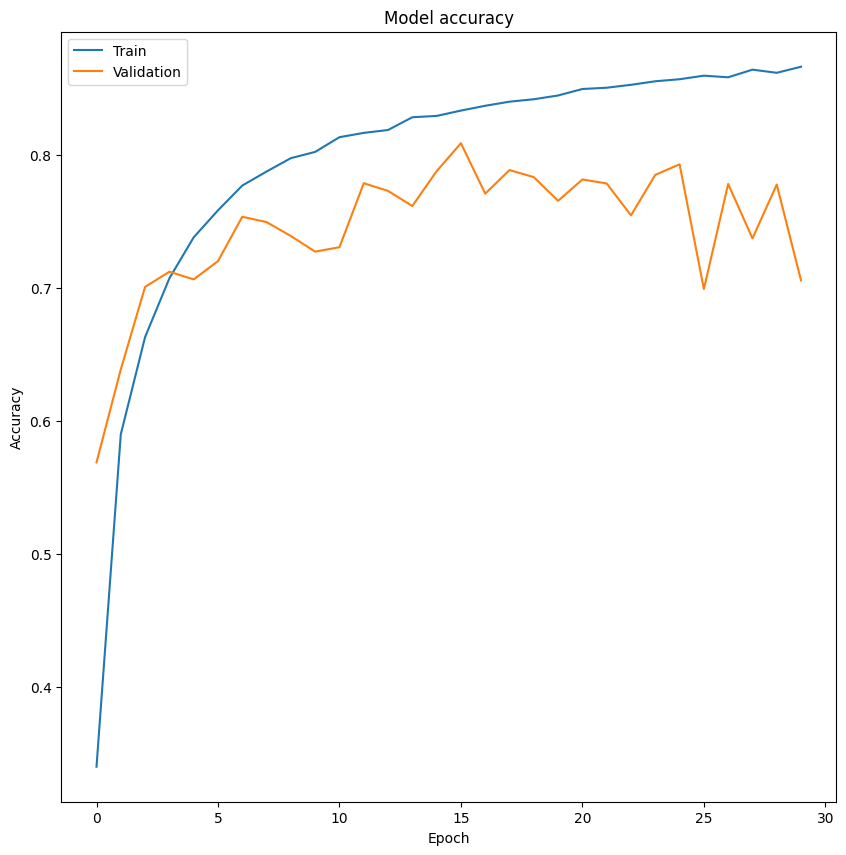

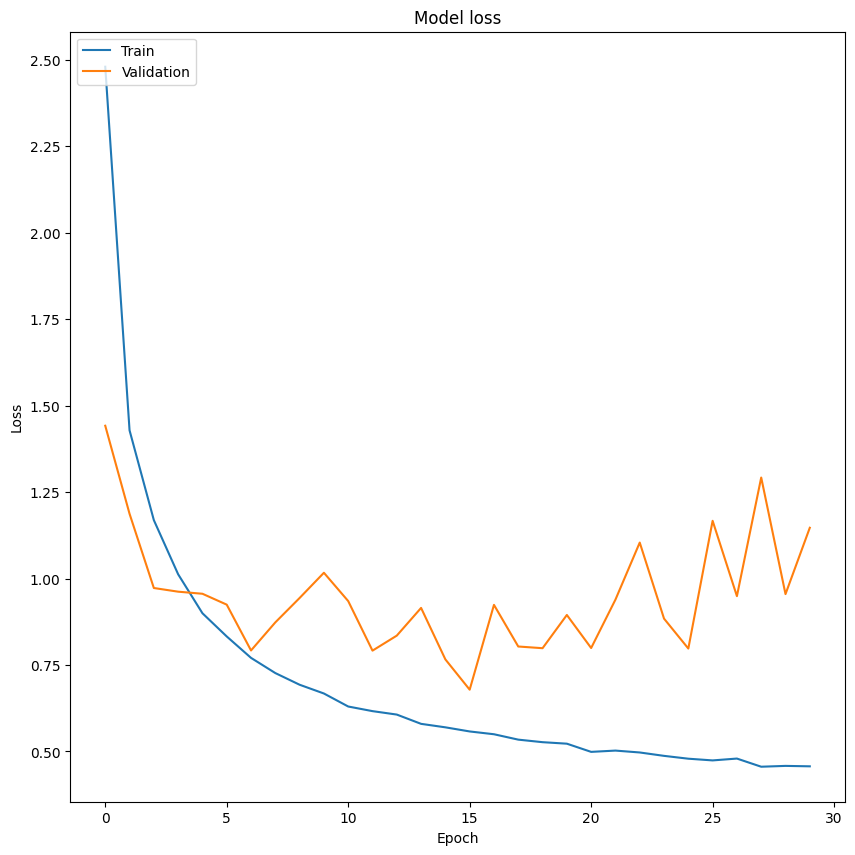

In [12]:
#Training and Validation Loss/Accuracy Plots
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10), dpi=100)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 10), dpi=100)
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [14]:
# Access the history object and print the accuracy and loss values numerically
print("Epoch | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss")
print("-" * 75)
for i in range(len(history.history['accuracy'])):
    print(f"{i + 1:5} | {history.history['accuracy'][i]:18.4f} | {history.history['val_accuracy'][i]:20.4f} | {history.history['loss'][i]:14.4f} | {history.history['val_loss'][i]:16.4f}")


Epoch | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss
---------------------------------------------------------------------------
    1 |             0.3397 |               0.5686 |         2.4799 |           1.4417
    2 |             0.5898 |               0.6386 |         1.4284 |           1.1871
    3 |             0.6629 |               0.7006 |         1.1688 |           0.9725
    4 |             0.7071 |               0.7120 |         1.0123 |           0.9619
    5 |             0.7379 |               0.7063 |         0.8996 |           0.9559
    6 |             0.7582 |               0.7200 |         0.8325 |           0.9244
    7 |             0.7769 |               0.7534 |         0.7705 |           0.7919
    8 |             0.7874 |               0.7494 |         0.7266 |           0.8731
    9 |             0.7975 |               0.7389 |         0.6928 |           0.9437
   10 |             0.8022 |               0.7271 |         0.6675 |

In [18]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)  # Apply the same scaling as done for the training data

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    directory='/Users/rohan/Desktop/FinalProject /FYP /new code/new_plant_images/split/test',  # Path to test data
    target_size=(256, 256),  # Same as training data
    color_mode='rgb',  
    batch_size=100,
    class_mode='categorical', 
    shuffle=False)  

# Load the trained model
from keras.models import load_model
model = load_model('/Users/rohan/Desktop/FinalProject /FYP /new code/Model_V1_model.h5')

loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Found 15938 images belonging to 64 classes.
160/160 [==============================] - 81s 506ms/step - loss: 1.1454 - accuracy: 0.7035
Test Loss: 1.1454
Test Accuracy: 0.7035


In [20]:
# Calculate F1 score
from sklearn.metrics import f1_score
import numpy as np

test_generator.shuffle = False
test_generator.batch_size = 1

# Generate predictions
y_true = []
y_pred = []
for _ in range(len(test_generator)):
    x, y = next(test_generator)
    y_true.extend(np.argmax(y, axis=1))  # True labels
    preds = model.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))  # Predicted labels

f1 = f1_score(y_true, y_pred, average='macro') 
print("F1 Score", f1)


1/1 [==============================] - 0s 44ms/step
F1 Score 0.6578296308332522
